<a href="https://colab.research.google.com/github/ZKisielewska/learning-git-task/blob/master/M_15_6_Pipeline_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the **penguins.csv** [download](https://uploads.kodilla.com/bootcamp/ds/14/penguins.csv) dataset, which contains features for different species of penguins. We will build Pipeline for this dataset.

In [8]:
# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# split of data into training/validation/test sets
from sklearn.model_selection import train_test_split, GridSearchCV

# creating Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# dimensionality reduction
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [9]:
# download 'penquins' data
penguins = pd.read_csv('https://uploads.kodilla.com/bootcamp/ds/14/penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [10]:
X = penguins.drop(['Species'] , axis=1).copy()
y = penguins['Species'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
num_features = ['CulmenLength' , 'CulmenDepth' , 'FlipperLength' , 'BodyMass']
print('Raw dataset - training set:')
print(X_train[num_features].isnull().mean())
print('Raw dataset - test set:')
print(X_test[num_features].isnull().mean())

Raw dataset - training set:
CulmenLength     0.007752
CulmenDepth      0.007752
FlipperLength    0.007752
BodyMass         0.007752
dtype: float64
Raw dataset - test set:
CulmenLength     0.0
CulmenDepth      0.0
FlipperLength    0.0
BodyMass         0.0
dtype: float64


In [11]:
# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# transformer
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

data_preparation.fit_transform(X_train)

array([[  48.1,   16.4,  199. , 3325. ],
       [  44.4,   17.3,  219. , 5250. ],
       [  50.4,   15.7,  222. , 5750. ],
       ...,
       [  40.2,   20.1,  200. , 3975. ],
       [  39.7,   17.9,  193. , 4250. ],
       [  40.2,   17.1,  193. , 3400. ]])

In [12]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', LogisticRegression(max_iter=10000))])

In [13]:
# function that calculates metrics and shows plots
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_name = []
prediction_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
  models.append(model)
  models_name.append(name)
  global metrics_dataframe
  predictions = model.predict(X_checked)
  predictions_proba = model.predict_proba(X_checked)
  prediction_proba_list.append(predictions_proba[:, 1])

  # metrics for the model being checked
  print(classification_report(y_checked, predictions))

  # Confusion matrix
  plt.figure()
  cm = confusion_matrix(y_checked, predictions)
  ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
  ax.set_title('Confusion Matrix\n\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values')
  plt.show()

  # plot ROC curve
  fig = plt.figure(figsize=(6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  for model_selected, name_selected, pred_proba in zip(models, models_name, prediction_proba_list):
    fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
    plt.plot(fpr, tpr, label=name_selected)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

  f1_metric = f1_score(y_checked, predictions, average='weighted')
  auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class='ovo')
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                               ignore_index=True)
  return metrics_dataframe

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



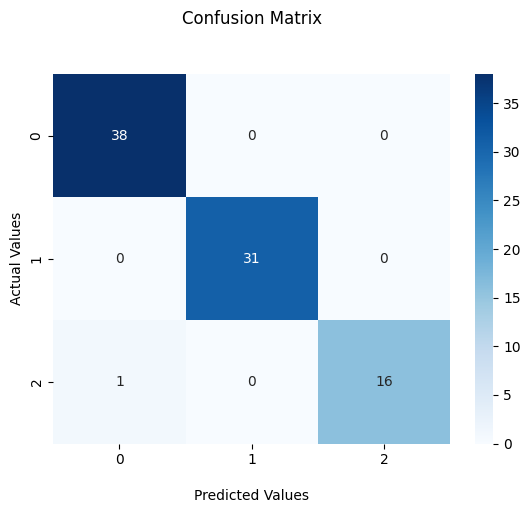

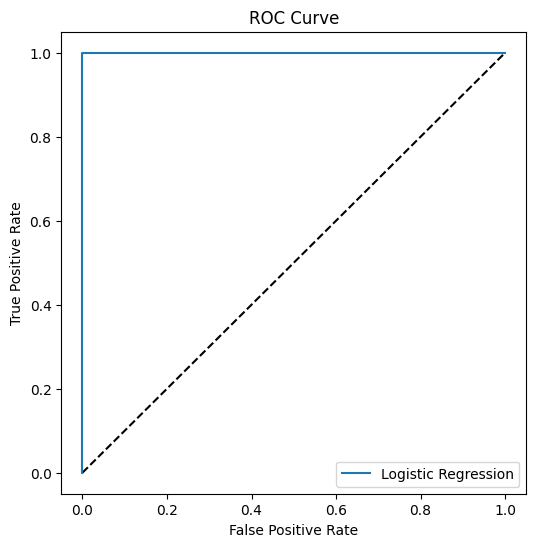

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.0


In [15]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [16]:
# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])
# transformer
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



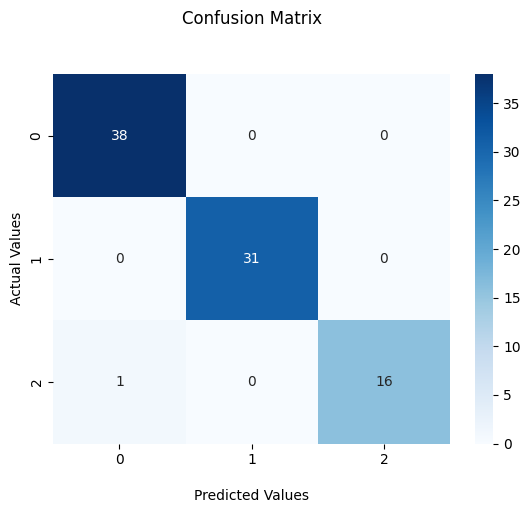

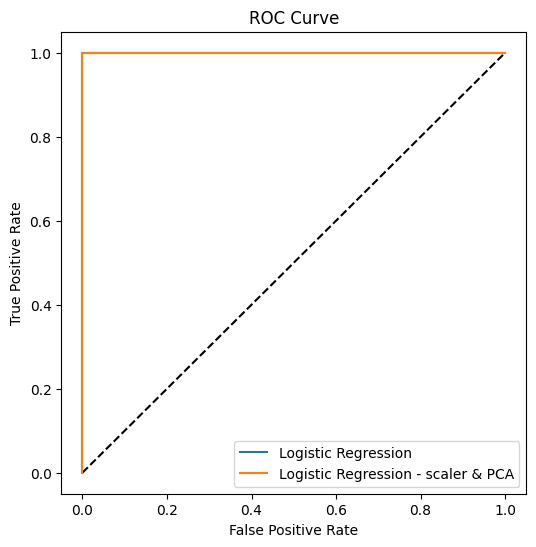

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.0
1,Logistic Regression - scaler & PCA,0.988271,1.0


In [17]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression - scaler & PCA', X_test, y_test)

In [18]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [19]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_preprocessing__fill_missings__keep_empty_featu

In [21]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Selected hyperparameters: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Selected hyperparameters:  {'model__C': 16.768329368110066, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.9, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 1}


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



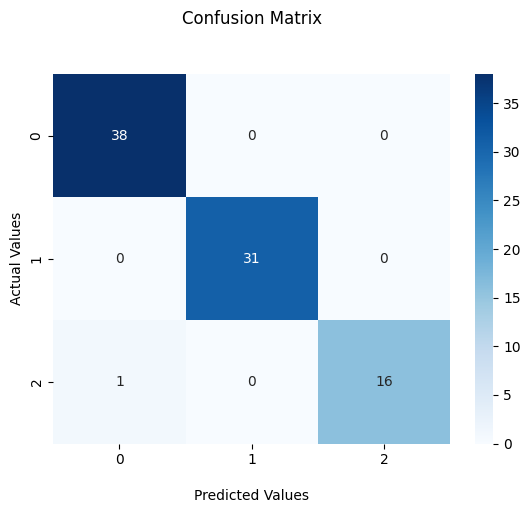

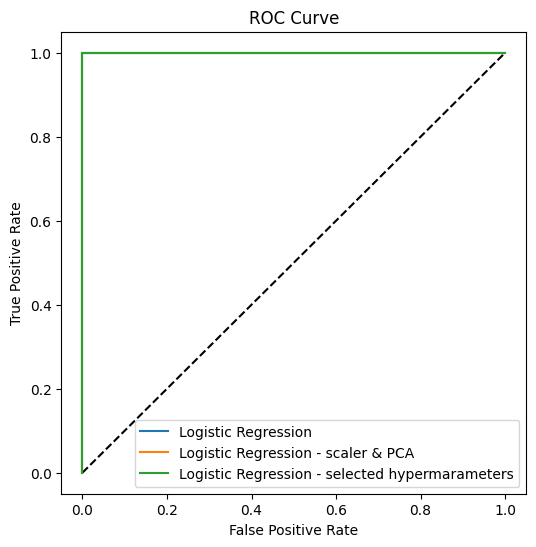

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.0
1,Logistic Regression - scaler & PCA,0.988271,1.0
2,Logistic Regression - selected hypermarameters,0.988271,1.0


In [22]:
calculate_metrics(model_v3, 'Logistic Regression - selected hypermarameters', X_test, y_test)

All three models work very well.